This notebook take inspiration from the Nvidia's [SegNet](https://github.com/dusty-nv/pytorch-segmentation/tree/master).

In [1]:
import torchvision
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from dataclasses import dataclass
from pathlib import Path

from semantic_segmentation.dataset import get_sets as get_semantic_sets
from semantic_segmentation.dataset import InputType
from ipywidgets import interact
from utils.dataset import get_dataloader
from params import PROJECT_PATH
from sam_pipeline_utils import compute_semantic_segmentation, CostType
from semantic_segmentation.sam_pipeline_utils import downsample_to_grid


device = "cuda"

# Config

In [2]:
@dataclass
class SegTrainingConfig:
    dataset_dir: Path = (
        PROJECT_PATH / "datasets/Distillation dataset/dataset_distillation_all"
    )
    weights: str = torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
    batch_size: int = 64
    num_epochs: int = 100
    lr: float = 1e-3
    lr_max_decay: float = 0.01
    lr_decay_step: int = 50


config = SegTrainingConfig()

In [3]:
# XXX: debug
config = SegTrainingConfig(
    dataset_dir=PROJECT_PATH
    / "datasets/Distillation dataset/fake_dataset_distillation",
)

# Dataset

In [4]:
train_set, val_set, test_set = get_semantic_sets(
    config.dataset_dir,
    image_augmentation_transform=None,
    geometric_augmentation_transform=None,
)
train_loader, val_loader, test_loader = get_dataloader(
    train_set, val_set, test_set, batch_size=config.batch_size
)

# Model

In [6]:
torchvision.models.list_models(torchvision.models.segmentation)

['deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'fcn_resnet101',
 'fcn_resnet50',
 'lraspp_mobilenet_v3_large']

In [7]:
model = torchvision.models.segmentation.fcn_resnet50(
    weights=config.weights,
    progress=True,
)

# Adapt for our task of traversal semantic segmentation
model.classifier[-1] = torch.nn.Conv2d(
    512, 1, kernel_size=(1, 1), stride=(1, 1)
)
model.aux_classifier[-1] = torch.nn.Conv2d(
    256, 1, kernel_size=(1, 1), stride=(1, 1)
)

In [8]:
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

# Training

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, 1, config.lr_max_decay, config.lr_decay_step
)

In [10]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = torch.nn.functional.mse_loss(x, target.unsqueeze(1))

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]


def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    return avg_train_loss


def evaluate(model, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_pred_val = model(x_val)["out"]
            val_loss += torch.nn.functional.mse_loss(
                y_pred_val, y_val.unsqueeze(1)
            ).item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

In [11]:
def train_model(config, model):
    progress_bar = tqdm(range(config.num_epochs), desc="Epoch")
    train_loss_list = []
    val_loss_list = []

    for _ in progress_bar:
        train_loss = train(model, train_loader, optimizer, device)
        val_loss = evaluate(model, val_loader, device)

        lr_scheduler.step()
        progress_bar.set_description(
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch"
        )

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

    return train_loss_list, val_loss_list

In [ ]:
train_model(config, model)

In [ ]:
train_loss_list, val_loss_list = train_model(config, model)

In [14]:
torch.save(model.state_dict(), "logs/model_2.pth")

In [27]:
weights = torch.load("logs/model_2.pth")
model.load_state_dict(weights)

<All keys matched successfully>

# Results?

Text(0, 0.5, 'Loss')

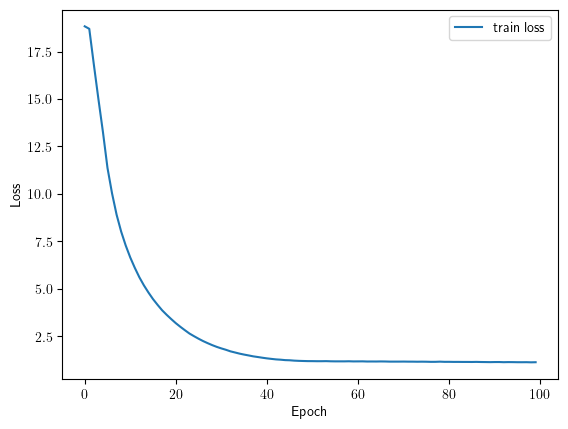

In [50]:
plt.plot(train_loss_list, label="train loss")
# plt.plot(val_loss_list, label="val loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [29]:
from skimage.transform import resize

visualization_set = train_set


@interact
def visualize_prediction(index: int = (0, len(visualization_set) - 1)):
    model.eval()
    with torch.no_grad():
        image, target = visualization_set[index]
        image = image.unsqueeze(0).to(device)
        output = model(image)["out"]

    _, axes = plt.subplots(1, 5, figsize=(30, 4))

    test_index = visualization_set.indexes[index]
    whole_image_path = config.dataset_dir / f"images/{test_index:05d}.png"
    whole_image = plt.imread(whole_image_path)
    axes[0].imshow(whole_image)
    axes[0].imshow(whole_image)
    axes[0].axhline(whole_image.shape[0] // 2, linestyle="dotted", color="red")
    axes[0].axis("off")
    axes[0].set_title("Source Image")

    axes[1].imshow(
        target.squeeze().cpu().numpy(), cmap="hot_r", vmin=2, vmax=6
    )
    axes[1].set_title("Target")
    axes[1].axis("off")
    colorbar = axes[2].imshow(
        output.squeeze().cpu().numpy(), cmap="hot_r", vmin=2, vmax=6
    )
    axes[2].set_title("Predicted Result")
    axes[2].axis("off")

    plt.colorbar(colorbar, ax=axes, shrink=0.5, location="bottom")

    whole_target = np.load(
        config.dataset_dir / f"targets/{test_index:05d}.npy"
    )

    output = output.squeeze().cpu().numpy()
    top_half = np.full_like(output, 5)
    whole_output = np.vstack((top_half, output))

    whole_output = resize(
        whole_output,
        whole_target.shape,
        mode="reflect",
        anti_aliasing=True,
    )

    costmap1 = downsample_to_grid(whole_target)
    costmap2 = downsample_to_grid(whole_output)

    axes[3].imshow(costmap1, cmap="hot_r", vmin=2, vmax=6)
    axes[3].set_title("Target Costmap")
    axes[3].axis("off")
    axes[4].imshow(costmap2, cmap="hot_r", vmin=2, vmax=6)
    axes[4].set_title("Predicted Costmap")
    axes[4].axis("off")

interactive(children=(IntSlider(value=3, description='index', max=7), Output()), _dom_classes=('widget-interac…

# Benchmarking models

## Distilled model

In [18]:
from timeit import timeit

model.eval()
benchmark_image, _ = test_set[0]
benchmark_image = benchmark_image.unsqueeze(0).to(device)

In [19]:
%%script false --no-raise-error
%%timeit

with torch.no_grad():
    model(benchmark_image)

## Full SAM pipeline

In [20]:
def get_image(img_path: Path) -> np.array:
    with Image.open(img_path) as pil_img:
        pil_img = pil_img.resize((180, 320))
        return np.array(pil_img)


img = get_image(config.dataset_dir / "images" / "00000.png")
depth = get_image(config.dataset_dir / "images" / "00000d.png")
normal = get_image(config.dataset_dir / "images" / "00000n.png")

In [21]:
%%script false --no-raise-error
%%timeit

with torch.no_grad():
    compute_semantic_segmentation(
        img,
        depth,
        normal,
        should_fill_segmentation=True,
        cost_type=CostType.CENTERED,
        should_filter_intersection=True,
        completeness_threshold=0,
    )

## Plot

In [22]:
%%script false --no-raise-error

# XXX: time written below are computed with the 2 above %%timeit
sam_pipeline_time = 2900
distilled_pipeline_time = 4

values = [sam_pipeline_time, distilled_pipeline_time]
labels = [
    "SAM pipeline",
    f"Distilled pipeline (x{sam_pipeline_time // distilled_pipeline_time} faster)",
]

plt.bar(labels, values, color=["firebrick", "limegreen"])
plt.xlabel("Model")
plt.ylabel("Time (in log)")
plt.yscale("log")
plt.title("Comparison of SAM_pipeline and distilled_pipeline")

# Profiling Training

In [23]:
from torch.profiler import profile, ProfilerActivity

In [51]:
%%script false --no-raise-error

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True,
    with_stack=True,
) as prof:
    train(model, train_loader, optimizer, device)

STAGE:2023-12-14 11:50:11 38898:38898 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-12-14 11:50:12 38898:38898 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-12-14 11:50:12 38898:38898 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [52]:
%%script false --no-raise-error

prof.export_chrome_trace("trace.json")

In [26]:
%%script false --no-raise-error

print(prof.key_averages().table(sort_by="cpu_time_total"))